In [1]:
import pandas as pd
from tqdm.auto import tqdm
import re
from transformers import AutoTokenizer, AutoModelForMaskedLM
from sklearn.model_selection import train_test_split
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model

import tensorflow as tf
import numpy as np 
import tensorflow as tf 

if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")
is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
print(tf.config.list_physical_devices('GPU'))

assert tf.test.is_gpu_available()
assert tf.test.is_built_with_cuda()

Default GPU Device:/device:GPU:0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def clean_text(text):
    text = text.replace("#", "")
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', "", text)
    text = re.sub('@\\w+ *', '', text, flags=re.MULTILINE)
    return text


In [3]:
data = pd.read_json('../../data/data.json')
data = data.filter(['comments'])
data.head(2)

,comments
0,"[{'user': 'Occamova mačeta', 'date': '0202-12-..."
1,"[{'user': 'Muka Lesec', 'date': '0202-03-02 09..."


In [4]:
comment_likes = {"comment":[], "likes":[]}
for i, row in tqdm(data.iterrows(), total=data.shape[0], position=0, leave=False):
    for comment in row["comments"]:
        comment_likes["likes"].append(int(comment["likes"]))
        comment_likes["comment"].append(comment["comment"])

data = pd.DataFrame(comment_likes)
data = data.drop_duplicates()

data['comment'] = data["comment"].apply(clean_text)

data = data[data["comment"] != '']
data = data.dropna(subset=['comment'])

data.head(5)

  0%|          | 0/9148 [00:00<?, ?it/s]

,comment,likes
0,"Ni treba. So že Kitajci rekli, da je prišlo od...",9
1,"Naši vrli forumaši samo ponavljajo tisto, kar ...",5
2,Profesor Luc Montagnier je vrhunski virolog in...,6
6,"Trdi tudi, da je del sekvence genoma virusa Sa...",4
7,"""...Strokovnjaki niso več prepričani, da je bi...",3


### Model

In [5]:
X = (np.array(data['comment']))
y = (np.array(data['likes']))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print("Train dataset shape: {0}, \nTest dataset shape: {1} \nValidation dataset shape: {2}".format(X_train.shape, X_test.shape, X_val.shape))

Train dataset shape: (96900,), 
Test dataset shape: (12113,) 
Validation dataset shape: (12112,)


In [6]:
tokenizer = AutoTokenizer.from_pretrained("EMBEDDIA/sloberta")
model = AutoModelForMaskedLM.from_pretrained("EMBEDDIA/sloberta")

In [7]:
def get_token_ids(texts):
    # return tokenizer.batch_encode_plus(texts, add_special_tokens=True, padding='max_length', max_length=512)["input_ids"]
    return [tokenizer(text, padding='max_length', max_length = 512, truncation=True)["input_ids"] for text in tqdm(texts)]


train_size = 50000 #len(X_train)
test_size = len(X_test)

train_token_ids = get_token_ids(list(X_train)[:train_size])
test_token_ids = get_token_ids(list(X_test)[:test_size])

y_train_set = y_train[:train_size]
y_test_set = y_test[:test_size]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
train_data = tf.data.Dataset.from_tensor_slices((tf.constant(train_token_ids), tf.constant(y_train_set))).batch(12)
test_data = tf.data.Dataset.from_tensor_slices((tf.constant(test_token_ids), tf.constant(y_test_set))).batch(12)

print(f"Train: {train_data}")
print(f"Test: {test_data}")

Train: <BatchDataset shapes: ((None, 512), (None,)), types: (tf.int32, tf.int64)>
Test: <BatchDataset shapes: ((None, 512), (None,)), types: (tf.int32, tf.int64)>


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFCamembertModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'roberta.embeddings.position_ids', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFCamembertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFCamembertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFCamembertModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down

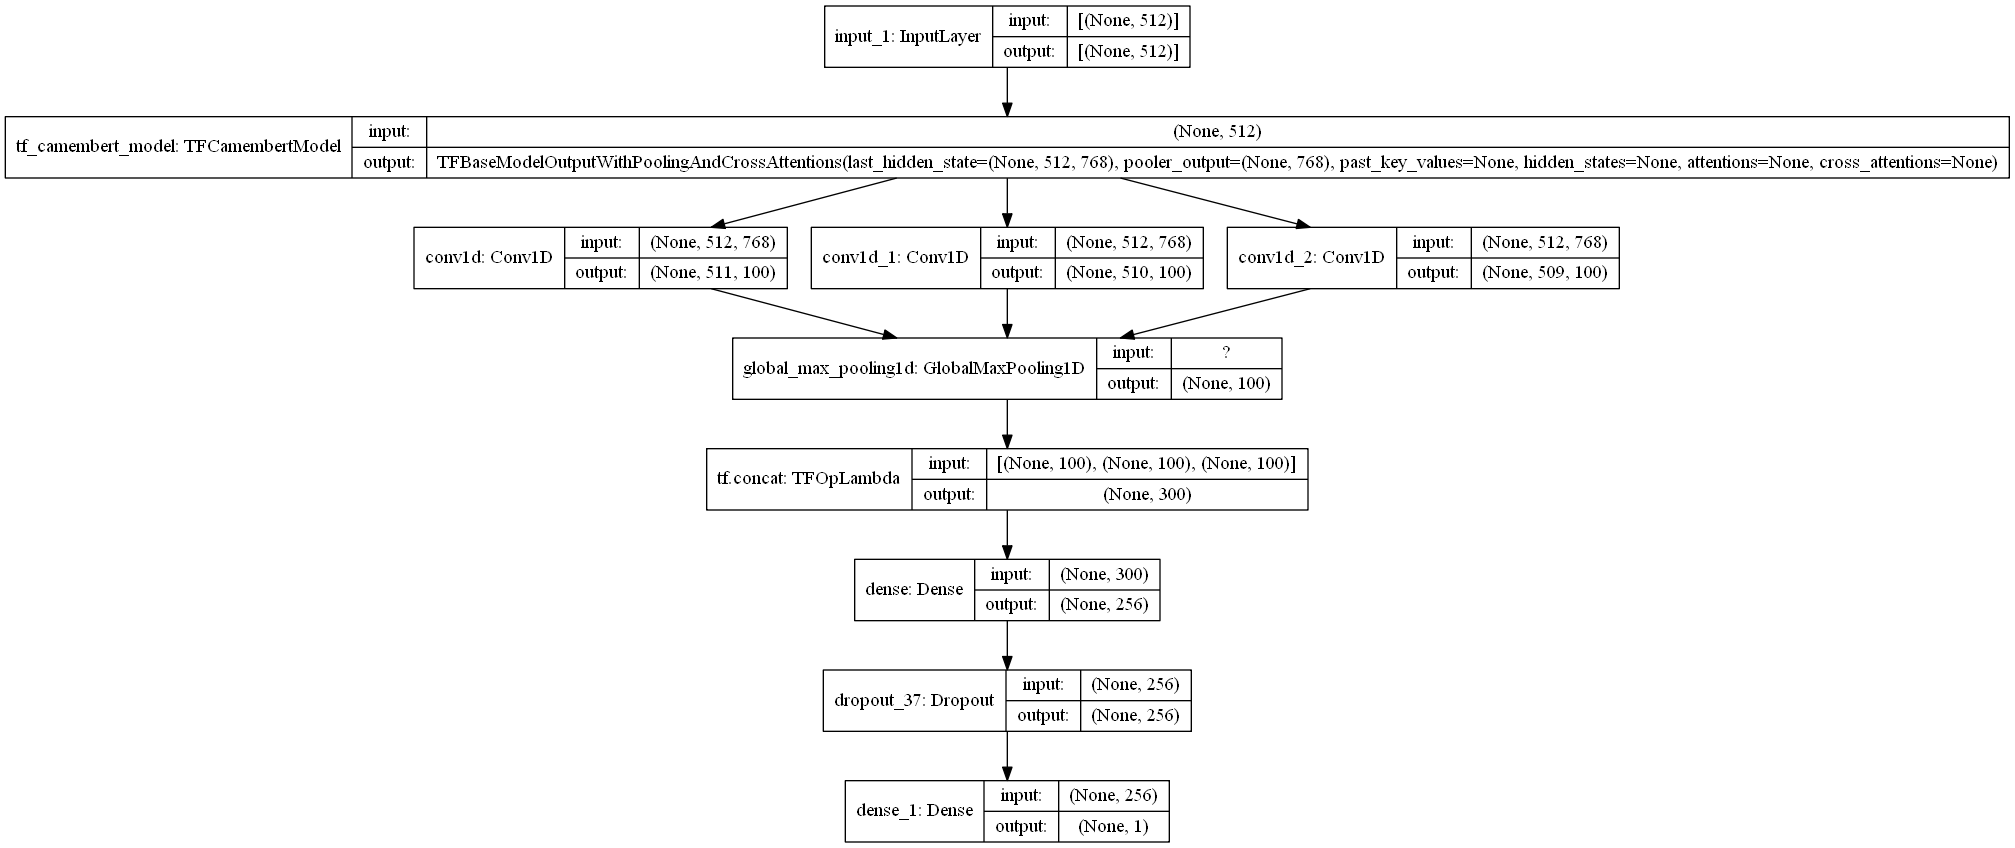

In [9]:
from transformers import TFCamembertModel
from tensorflow.keras import layers

CNN_FILTERS = 100
DNN_UNITS = 256
DROPOUT_RATE = 0.2
NB_EPOCHS = 5

bert_layer = TFCamembertModel.from_pretrained('EMBEDDIA/sloberta', from_pt=True, trainable=False)
cnn_layer1 = layers.Conv1D(filters=CNN_FILTERS, kernel_size=2, padding="valid", activation="relu")
cnn_layer2 = layers.Conv1D(filters=CNN_FILTERS, kernel_size=3, padding="valid", activation="relu")
cnn_layer3 = layers.Conv1D(filters=CNN_FILTERS, kernel_size=4, padding="valid", activation="relu")
pool = layers.GlobalMaxPool1D()
dense_1 = layers.Dense(units=DNN_UNITS, activation="relu")
dropout = layers.Dropout(rate=DROPOUT_RATE)
last_dense = layers.Dense(units=1, activation="linear")

inputs = tf.keras.Input(shape=(512,), dtype=np.int32)

bert_outputs = bert_layer(inputs)
l_1 = cnn_layer1(bert_outputs[0]) 
l_1 = pool(l_1) 
l_2 = cnn_layer2(bert_outputs[0]) 
l_2 = pool(l_2)
l_3 = cnn_layer3(bert_outputs[0])
l_3 = pool(l_3)
concatenated = tf.concat([l_1, l_2, l_3], axis=-1)
concatenated = dense_1(concatenated)
concatenated = dropout(concatenated)
outputs = last_dense(concatenated)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="slobert_likes")
model.compile(optimizer='adam',
                loss='mse',
                metrics=['mae'])

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [10]:
NB_EPOCHS = 5
iter_per_save = 1
save_freq = int(iter_per_save * (y_train_set.shape[0] / 12) + 1)
checkpoint_path = "checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1, 
                                                 save_freq=save_freq)
model.fit(train_data, epochs=NB_EPOCHS, callbacks=[cp_callback])

Epoch 1/5
17/17 [==============================] - ETA: 0s - loss: 1246.7965 - mae: 21.3678
Epoch 00001: saving model to checkpoints\cp-0001.ckpt
17/17 [==============================] - 26s 643ms/step - loss: 1246.7965 - mae: 21.3678
Epoch 2/5
17/17 [==============================] - ETA: 0s - loss: 1203.5757 - mae: 19.8930
Epoch 00002: saving model to checkpoints\cp-0002.ckpt
17/17 [==============================] - 11s 624ms/step - loss: 1203.5757 - mae: 19.8930
Epoch 3/5
17/17 [==============================] - ETA: 0s - loss: 1161.0515 - mae: 21.2750
Epoch 00003: saving model to checkpoints\cp-0003.ckpt
17/17 [==============================] - 12s 712ms/step - loss: 1161.0515 - mae: 21.2750
Epoch 4/5
17/17 [==============================] - ETA: 0s - loss: 1145.3149 - mae: 20.9300
Epoch 00004: saving model to checkpoints\cp-0004.ckpt
17/17 [==============================] - 13s 751ms/step - loss: 1145.3149 - mae: 20.9300
Epoch 5/5
17/17 [==============================] - ETA: 0s -

PREDICTIONS: 
mse: 612.0 
mae: 18.38 

BASELINE: 
mse: 585.8456000000001 
mae: 17.384799999999995 



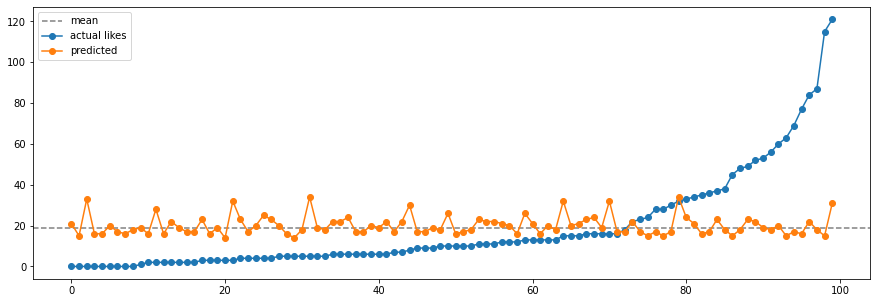

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt 

actual_likes = y_test_set
predicted_likes= [round(x[0]) for x in model.predict(test_data)]

actual_likes, predicted_likes = zip(*sorted(zip(actual_likes, predicted_likes), key=lambda item: item[0]))

mean = np.mean(actual_likes)
baseline = [mean for _ in range(len(actual_likes))]

result = pd.DataFrame({"actual likes": actual_likes, "predicted": predicted_likes})

mse = mean_squared_error(y_true=result['actual likes'],
                   y_pred=result['predicted'])
mae = mean_absolute_error(y_true=result['actual likes'],
                   y_pred=result['predicted'])

print(f"PREDICTIONS: \nmse: {mse} \nmae: {mae} \n")

mse = mean_squared_error(y_true=result['actual likes'],
                   y_pred=baseline)
mae = mean_absolute_error(y_true=result['actual likes'],
                   y_pred=baseline)

print(f"BASELINE: \nmse: {mse} \nmae: {mae} \n")

fig, ax = plt.subplots(figsize=(15, 5), facecolor='white')
ax.axhline(y = mean, color = 'gray', linestyle = 'dashed', label='mean')
ax.legend()
ax = result.plot(ax=ax, marker='o')